In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization, StatsBase, Statistics, ProgressMeter, SpecialFunctions

## In this notebook we will implement a  Theory Of Mind agents on a version of Poker

### Kuhn Poker

Kuhn poker is an extremely simplified form of poker developed by Harold W. Kuhn as a simple model zero-sum two-player imperfect-information game, amenable to a complete game-theoretic analysis. In Kuhn poker, the deck includes only three playing cards, for example a King, Queen, and Jack. One card is dealt to each player, which may place bets similarly to a standard poker. If both players bet or both players pass, the player with the higher card wins, otherwise, the betting player wins.

#### Rules

In conventional poker terms, a game of Kuhn poker proceeds as follows:

Each player antes 1.
Each player is dealt one of the three cards, and the third is put aside unseen.
Player one can check or bet 1.
* If player one checks then player two can check or bet 1.
    * If player two checks there is a showdown for the pot of 2 (i.e. the higher card wins 1 from the other player).
    * If player two bets then player one can fold or call.
        * If player one folds then player two takes the pot of 3 (i.e. winning 1 from player 1).
        * If player one calls there is a showdown for the pot of 4 (i.e. the higher card wins 2 from the other player).
* If player one bets then player two can fold or call.
    * If player two folds then player one takes the pot of 3 (i.e. winning 1 from player 2).
    * If player two calls there is a showdown for the pot of 4 (i.e. the higher card wins 2 from the other player).

#### Optimal strategy


The game has a mixed-strategy Nash equilibrium; when both players play equilibrium strategies, the first player should expect to lose at a rate of −1/18 per hand (as the game is zero-sum, the second player should expect to win at a rate of +1/18). There is no pure-strategy equilibrium.

Kuhn demonstrated there are infinitely many equilibrium strategies for the first player, forming a continuum governed by a single parameter. In one possible formulation, player one freely chooses the probability $\alpha$ $\in$ [0,1/3] with which he will bet when having a Jack (otherwise he checks; if the other player bets, he should always fold). When having a King, he should bet with the probability of $3\alpha$ (otherwise he checks; if the other player bets, he should always call). He should always check when having a Queen, and if the other player bets after this check, he should call with the probability of $\alpha$ +1/3.

The second player has a single equilibrium strategy: Always betting or calling when having a King; when having a Queen, checking if possible, otherwise calling with the probability of 1/3; when having a Jack, never calling and betting with the probability of 1/3.

#### Pseudo Code Model

* game_simulation(num_of_round):
    * c1 , c2 ~ Deck() <br>

    * player1_history = [] <br>
    * player2_history = [] <br>

    * for i in length(num_of_rounds):
       * m1 = agent(c1, player2_history, deception_alpha) <br>
       * player1_history.append(m1) <br>
       * m2 = agent(c2, player1_history, deception_alpha) <br>
       * player2_history.append(m2) <br>
<br><br><br>
* agent(card , opp_history, decption_alpha):
    * opp_card ~ Deck(deck.pop(card))
    * opp_move ~ opp_model(opp_card, last_action)
    * return select_move(opp_move, card, deception_alpha)

In [4]:
JACK = 1
QUEEN = 2
KING = 3
FULL_DECK = [JACK, QUEEN, KING]

3-element Array{Int64,1}:
 1
 2
 3

In [63]:
FOLD = -1
CHECK = 0
BET = 1
ACTIONS = [FOLD, CHECK, BET]

3-element Array{Int64,1}:
 -1
  0
  1

#### This method is implementation of first player equilibrium strategy

In [133]:
function first_player_select_move(card, deception_alpha, opp_betting)
   if card == JACK
        if opp_betting
            return FOLD    
        elseif rand() < deception_alpha
            return BET # bluff
        else
            return CHECK
        end
    elseif card == KING
        need_to_bet = rand() < 3 * deception_alpha
        if need_to_bet && !opp_betting
            return BET
        else   # slow playing
            return CHECK
        end
    else # queen
        need_to_call = rand() < deception_alpha + 1/3
        if !need_to_call && opp_betting
            return FOLD
        else
            return CHECK
        end
    end
end

first_player_select_move (generic function with 2 methods)

#### This method is implementation of second player equilibrium strategy

In [137]:
function second_player_select_move(card, opp_betting)
   if card == JACK
        if opp_betting
            return FOLD    
        elseif rand() < 1/3
            return BET # bluff
        else
            return CHECK
        end
    elseif card == KING
        if  opp_betting
            return CHECK
        else   # slow playing
            return BET
        end
    else # queen
        need_to_call = rand() < 1/3
        if !need_to_call && opp_betting
            return FOLD
        else
            return CHECK
        end
    end
end

second_player_select_move (generic function with 2 methods)

In [395]:
function round(first_card, second_card, deception_alpha = 0.2)
    first_player_move = first_player_select_move(first_card, deception_alpha, false)
    second_player_move = second_player_select_move(second_card, first_player_move == BET)
#     println("stage 1 first player: $first_player_move second player: $second_player_move")
    doubled_pot = first_player_move == BET || second_player_move == BET
    if second_player_move == FOLD
        return 1
    end
    if second_player_move == BET
        doubled_pot = true
        first_player_move = first_player_select_move(first_card, deception_alpha , true)
#         println("stage 2  first player: $first_player_move second player: $second_player_move")
        if first_player_move == FOLD
            return -1
        end
    end
    if first_card > second_card
        return 1 * (1 + doubled_pot)
    else
        return -1 * (1 + doubled_pot)
    end
end

round (generic function with 3 methods)

In [396]:
round(JACK, KING)

-1

In [387]:
function game(num_of_rounds = 10, deception_alpha=0.2)
    total_score = 0
    for i in 1:num_of_rounds
        first_card, second_card = sample(FULL_DECK, 2; replace=false)
        score = round(first_card, second_card, deception_alpha)
#         println("round $i: first player got $first_card second player got $second_card score is $score")
        total_score += score
    end
    avg_score = total_score / num_of_rounds
    return avg_score
end

game (generic function with 6 methods)

#### we can see that the game is converging to -1/18 as the theory states

In [398]:
game(1000000, 0.25)

-0.054661

In [399]:
game(1000000, 0.1)

-0.055494

In [400]:
game(1000000, 0.01)

-0.054462

### The PPL Approach

### let's try to infer the $\alpha$ seed

In [439]:
@model function agent(card, opp_betting = false)
    deception_alpha ~ Dirac(0.33333)
    if !opp_betting
        if card == JACK
            bet_chance ~ Bernoulli(deception_alpha) # bluff
            return ACTIONS[bet_chance+1]
        elseif card == KING
            check_chance ~ Bernoulli(3 * deception_alpha) # agrassive vs slow playing
            return ACTIONS[3-check_chance]
        else # queen
            return CHECK
        end
    else
        if card == JACK
            return FOLD
        elseif card == KING  
            return CHECK
        else  
            call_chance ~ Bernoulli(deception_alpha + 1/3) # bluff detection
            return ACTIONS[2-call_chance] 
        end
    end
end

agent (generic function with 3 methods)

#### Some simple games with the model

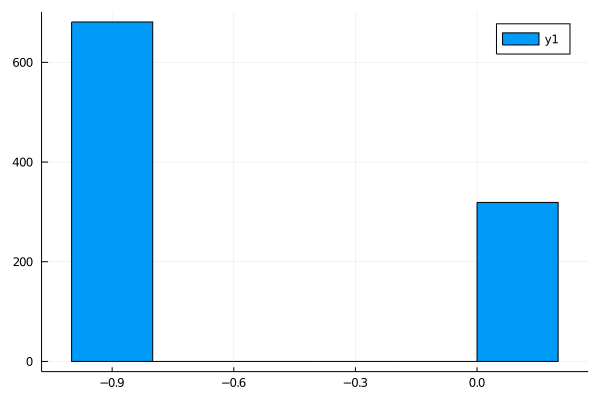

In [440]:
m = agent(JACK)
chains = sample(m, IS(), 1000 , n_chains=1)
histogram(generated_quantities(m, chains))

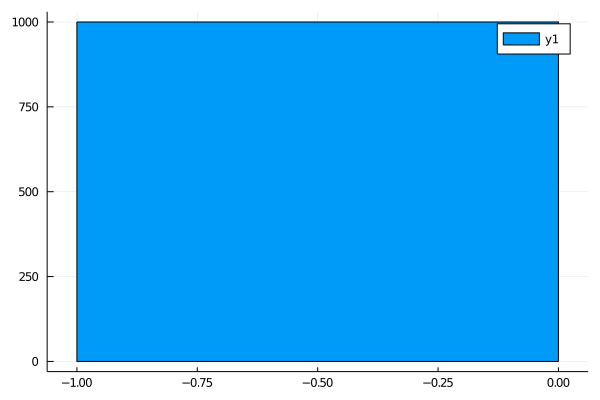

In [441]:
m  = agent(JACK, true)
chains = sample(m, IS(), 1000 , n_chains=1)
histogram(generated_quantities(m, chains))

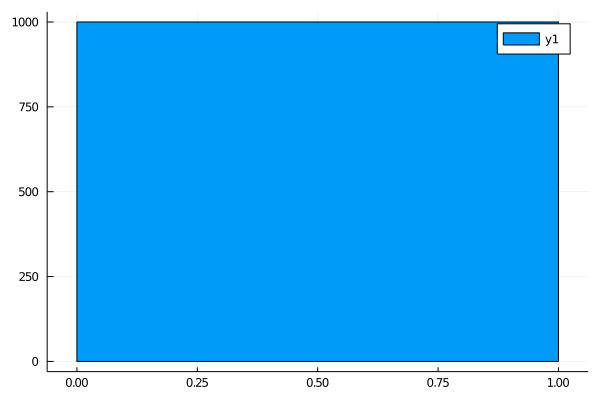

In [442]:
m = agent(QUEEN)
chains = sample(m, IS(), 1000 , n_chains=1, progress = true)
histogram(generated_quantities(m, chains))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


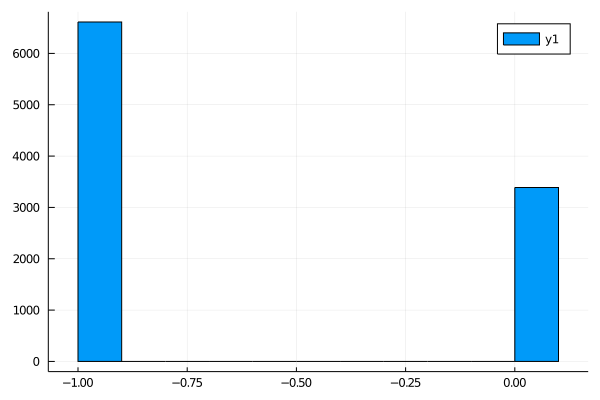

In [443]:
m = agent(QUEEN, true)
chains = sample(m, IS(), 10000 , n_chains=1, progress = true)
histogram(generated_quantities(m, chains))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


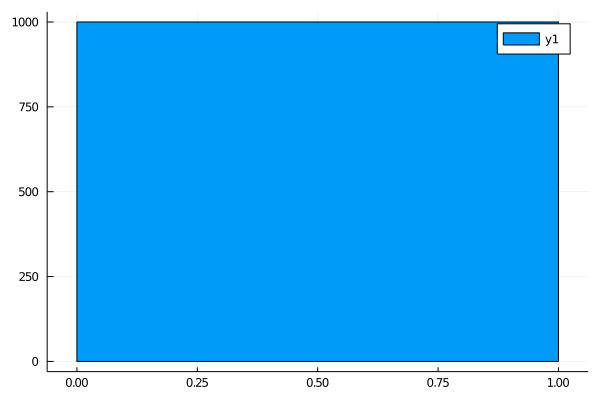

In [444]:
m = agent(KING)
chains = sample(m, IS(), 1000 , n_chains=1, progress = true)
histogram(generated_quantities(m, chains))

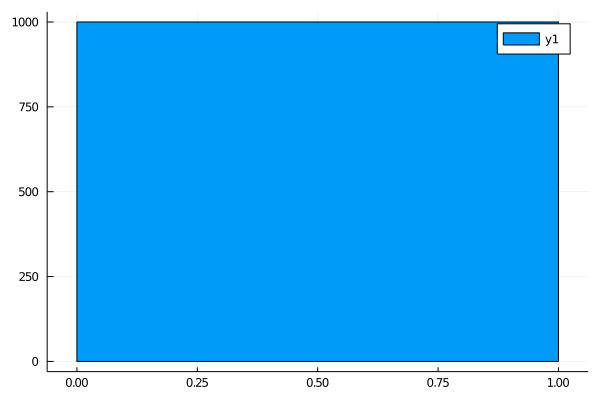

In [445]:
m = agent(KING, true)
chains = sample(m, IS(), 1000 , n_chains=1, progress = true)
histogram(generated_quantities(m, chains))

In [236]:
@model function agent(card, opponent_history, decpetion_alpha, opp_model)
    remaining_deck = setdiff(FULL_DECK, card)
    opp_card_index ~ Categorical([1,1])
    opp_card = remaining_deck[opp_card_index]
    opp_anticipated_move = opp_model(opp_card, opponent_history)
    return select_move(card, opp_anticipated_move, deception_alpha)
end

agent (generic function with 2 methods)

In [ ]:
function move(agent, other_agent, other_agent_history, my_history, my_estimated_opponent_policy, my_depth)
   sample
end

In [34]:
function game(first_player_depth = 1, second_player_depth = 1, first_player_bank = 10, second_player_bank = 10, num_of_rounds = 15)
    first_player = agent
    second_player = agent
    first_player_history = []
    second_player_history = []
    first_player_theoretical_score = []
    first_card, second_card = sample(FULL_DECK, 2; replace=false)
    println("first card is $first_card, second card is $second_card")
    # @showprogress  
    for i in 1:num_of_rounds
        if first_player_bank > 0 && second_player_bank > 0
            first_player_bank -= 1
            second_player_bank -= 1
        elseif first_player_bank > 0
            println("first player won!")
            break
        else
            println("second player won!")
            break
        end
    end
    return first_player_history, second_player_history, first_player_theoretical_score
 end

game (generic function with 6 methods)

In [35]:
game()

first card is 3, second card is 2
second player won!


(Any[], Any[], Any[])